C:\Users\vsavelev\AppData\Local\Temp\ipykernel_2844\3889565928.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

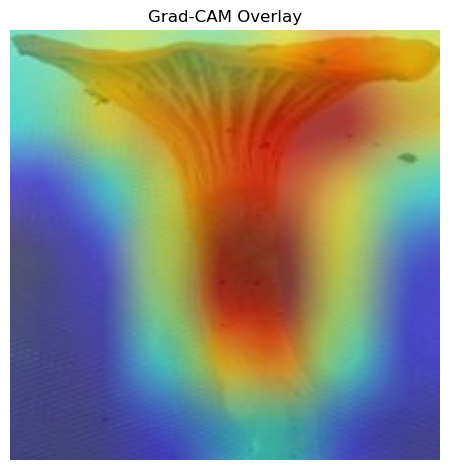

In [6]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.cm as cm

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activation_map = None
        
        # Hook the model to get gradients and activation maps
        self.model.layer4[1].register_backward_hook(self.backward_hook)
        self.model.layer4[1].register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        self.activation_map = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_index):
        # Forward pass
        output = self.model(input_tensor)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        class_loss = output[0][class_index]
        class_loss.backward()
        
        # Get the gradients and activation map
        gradients = self.gradients.data.numpy()[0]
        activation = self.activation_map.data.numpy()[0]
        
        # Compute weights
        weights = np.mean(gradients, axis=(1, 2))
        
        # Generate CAM
        cam = np.zeros(activation.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activation[i, :, :]
        
        # Apply ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize the CAM
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        
        return cam

def load_model(model_path):
    # Load the pre-trained model
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 23)  # Adjust for your specific task
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor, img  # Return original image for display

def display_gradcam(img, cam):
    # Ensure CAM is between 0 and 1
    cam = np.clip(cam, 0, 1)  # Clip values to be between 0 and 1
    cam = (cam * 255).astype(np.uint8)  # Convert to 0-255 range for visualization

    # Create a heatmap using the 'jet' colormap
    heatmap = cm.jet(cam)  # Apply the jet colormap
    heatmap = (heatmap[..., :3] * 255).astype(np.uint8)  # Convert to 8-bit RGB

    # Convert the CAM to a PIL image
    cam_image = Image.fromarray(heatmap)  # Create RGB heatmap image

    # Resize the heatmap to match the original image size
    cam_image = cam_image.resize(img.size, Image.LANCZOS)  # Use LANCZOS for high-quality resizing

    # Combine the original image with the heatmap
    overlay = Image.blend(img.convert("RGB"), cam_image, alpha=0.5)  # Overlay the images

    # Display the final result
    plt.imshow(overlay)
    plt.axis('off')  # Hide axes
    plt.title('Grad-CAM Overlay')
    plt.tight_layout()
    plt.show()

# Load the model
model_path = 'C:/Users/vsavelev/GITHUB/DS_projet/jan24_cds_mushrooms/models/artifacts/florent_resnet18.pth'
model = load_model(model_path)

# Load and preprocess the image
img_path = 'C:/Users/vsavelev/GITHUB/DS_projet/LAYER2/MO/validation/330/445178.jpg'  # Change to your image path
img_tensor, original_img = preprocess_image(img_path)

# Initialize Grad-CAM
grad_cam = GradCAM(model)

# Get the predicted class index
with torch.no_grad():
    output = model(img_tensor)
predicted_class_index = output.argmax(dim=1).item()

# Generate CAM
cam = grad_cam.generate_cam(img_tensor, predicted_class_index)

# Display results
display_gradcam(original_img, cam)


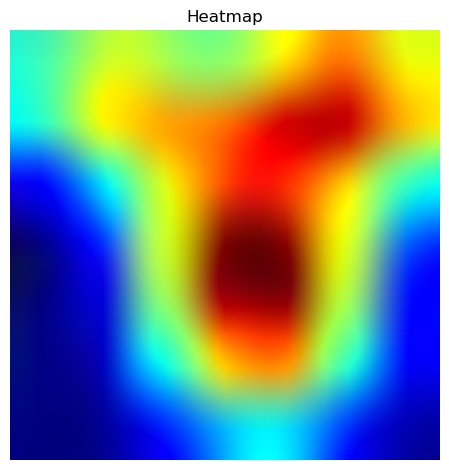

In [7]:
def plot_heatmap(cam, original_img):
    # Normalize the CAM
    cam = cam - np.min(cam)  # Shift to start from 0
    cam = cam / np.max(cam)  # Normalize to [0, 1]

    # Convert CAM to heatmap
    heatmap = cm.jet(cam)  # Apply jet colormap
    heatmap = np.uint8(heatmap[..., :3] * 255)  # Convert to 8-bit RGB

    # Create a PIL image from the heatmap
    heatmap_image = Image.fromarray(heatmap)

    # Resize the heatmap to match the original image size
    heatmap_image = heatmap_image.resize(original_img.size, Image.LANCZOS)

    # Display the heatmap
    plt.imshow(heatmap_image)
    plt.axis('off')  # Hide axis
    plt.title('Heatmap')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming 'cam' is your computed activation map and 'original_img' is the original image
plot_heatmap(cam, original_img)